# 📊 Final Project - Customer Churn Prediction for Sendo Farm

## Problem Definition

Sendo Farm is an online grocery e-commerce platform that delivers essential goods, similar to a supermarket, directly to consumers for their daily meals.  
Because the products are groceries—especially fresh items such as meat, fish, fruits, and vegetables—customer satisfaction is highly sensitive to quality.  

Some customers who are dissatisfied with product quality or after-sales service choose to file complaints, request refunds, or report missing items. However, many others leave silently without expressing dissatisfaction and never purchase from Sendo Farm again.  

Customer churn is costly, especially in the grocery business where customers make frequent and recurring purchases.  
Thus, the goal of this project is to build a **supervised machine learning model** that predicts which customers are at risk of churning. This will allow Sendo Farm to proactively take preventive actions, such as personalized campaigns, compensation, or loyalty offers, to improve customer experience and retention.  

### Dataset Description
The available data includes:
- **Customer infomation** (customerid, monthly_frequency, recency, days_stop_frequency, total_value, last_rating, avarage_rating, last_complain, last_refund, total_comlains, total_refunds) 
- **Transaction history** (customerid, orderid, orderdate,rating, is_compalained, order_value).
     

These features will be engineered into customer-level data suitable for supervised ML classification (churn vs non-churn).


In [76]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/hoangnp/cu_boulder/ML_Unsupervied_final_Project/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: @rpath/libomp.dylib\n  Referenced from: /Users/hoangnp/cu_boulder/ML_Unsupervied_final_Project/venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


## 1. Data Loading & Initial Merge

### Overview
This section focuses on loading and reviewing transaction data from the grocery_transactions.csv file, specifically targeting transactions from **June, July, and August 2025** for **10,000 customers**. The primary objectives are:

1. **Load the dataset** and perform initial data exploration
2. **Review data quality** and structure

3. **The printed out information as below:**

Total rows (transactions): 77,618

Unique customer IDs: 10,000

Data columns (total 9 columns):so.ordernumber, orderdate, order_value, customerid, applyclaimdate, refundguid, reasoncancelcode, rating, is_fresh



In [60]:
# 📊 Load grocery transactions data
df = pd.read_csv('../data/grocery_transactions.csv')

# Display basic information about the dataset
print(f"Total rows (transactions): {len(df):,}")
#Print unique customerid here 
print(f"Unique customer IDs: {df['customerid'].nunique():,}")
# Display column information
print("Column Information:")
print(df.info())


Total rows (transactions): 77,618
Unique customer IDs: 10,000
Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77618 entries, 0 to 77617
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   so.ordernumber    77618 non-null  int64  
 1   orderdate         77618 non-null  object 
 2   order_value       77618 non-null  float64
 3   customerid        77618 non-null  int64  
 4   applyclaimdate    560 non-null    object 
 5   refundguid        1161 non-null   object 
 6   reasoncancelcode  4475 non-null   object 
 7   rating            10261 non-null  float64
 8   is_fresh          77618 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.3+ MB
None


## 2. Preliminary Feature Engineering

Before diving deep into analysis, we'll create some essential customer-level features by aggregating the merged data. This gives us a basic dataset for initial exploration.

### Feature Aggregation
- **customerid**: Customer level group by (10K)
- **total_order**: Total number of orders per customer (count from ordernumber).
- **total_spend**: Sum of money spent by each customer (sum from order_value).
- **is_bad_rating**: Normalize rating given by the customer (If average rating < 3.5 then 1 else 0).
- **is_bad_last_rating**: Normalize last rating given by the customer (If most recent rating < 3.5 then 1 else 0).
- **total_incidents**: Total number of incidents (refunds, incidents) by a customer (count(refundguid) + count(applyclaimdate) ).
- **is_incident_last_order**: Was there an incident at last order (If last order is incident or refurnd then 1 else 0).
- **is_fresh_last_order**: Is there any fresh item in last order (If last order having is_fresh = true then 1 else 0). 
- **is_canceled_last order** Was the last order  cancelled? (If reasoncancelcode of last order is NOT NULL then 1 else 0 ).
- **Recency**: Number of days since the customer's last order ( Day('08-31-2925' - max(orderdate))).
- **is_churn**: This is also the label column (If Recency > 15 then 1 else 0).

Handle missing values 
Printed out the head and dataset info.

In [61]:
# Create customer-level features by aggregating transaction dat

# Ensure orderdate is datetime
df['orderdate'] = pd.to_datetime(df['orderdate'])

# Group by customerid and create aggregated features
customer_features = df.groupby('customerid').agg({
    'so.ordernumber': 'count',  # total_order
    'order_value': 'sum',       # total_spend
    'rating': 'last',           # last_rating only
    'refundguid': 'count',      # count refunds
    'applyclaimdate': 'count',  # count claims
    'reasoncancelcode': 'count', # count cancellations
    'is_fresh': 'last',         # is_fresh_last_order
    'orderdate': 'max'          # last_order_date
}).reset_index()

# Flatten column names
customer_features.columns = [
    'customerid', 'total_order', 'total_spend', 'last_rating',
    'total_refunds', 'total_claims', 'total_cancellations', 'is_fresh_last_order', 'last_order_date'
]

# Calculate avg_rating separately - only for orders with actual ratings (not NULL)
avg_rating_by_customer = df[df['rating'].notna()].groupby('customerid')['rating'].mean()
customer_features['avg_rating'] = customer_features['customerid'].map(avg_rating_by_customer)

# Calculate additional features
# 1. is_bad_rating: If average rating < 2.5 then 1 else 0 (only for customers with ratings)
customer_features['is_bad_rating'] = (customer_features['avg_rating'] < 2.5).astype(int)
# For customers with no ratings, is_bad_rating = 0 (neutral)
customer_features['is_bad_rating'] = customer_features['is_bad_rating'].fillna(0)

# 2. is_bad_last_rating: If most recent rating < 2.5 then 1 else 0
customer_features['is_bad_last_rating'] = (customer_features['last_rating'] < 2.5).astype(int)

# 3. total_incidents: Total number of incidents (refunds + claims)
customer_features['total_incidents'] = customer_features['total_refunds'] + customer_features['total_claims']

# 4. is_incident_last_order: Was there an incident at last order
# We need to check if the last order had an incident or refund
last_orders = df.sort_values('orderdate').groupby('customerid').tail(1)
last_orders_incidents = last_orders.set_index('customerid')[['refundguid', 'applyclaimdate']].notna().any(axis=1)
customer_features['is_incident_last_order'] = customer_features['customerid'].map(last_orders_incidents).fillna(0).astype(int)

# 5. is_canceled_last_order: Was the last order cancelled?
last_orders_canceled = last_orders.set_index('customerid')['reasoncancelcode'].notna()
customer_features['is_canceled_last_order'] = customer_features['customerid'].map(last_orders_canceled).fillna(0).astype(int)

# 6. Recency: Number of days since the customer's last order
reference_date = pd.to_datetime('2025-08-31')  # End of August 2025
customer_features['recency'] = (reference_date - customer_features['last_order_date']).dt.days

# 7. is_churn: If Recency > 15 then 1 else 0, Its also the label column
customer_features['is_churn'] = (customer_features['recency'] > 15).astype(int)

# Handle missing values
customer_features['last_rating'] = customer_features['last_rating'].fillna(0)

#Drop recency as it leaks the lablel
#customer_features.drop(columns=['recency'], inplace=True)
# Display basic information
print(customer_features.info())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerid              10000 non-null  int64         
 1   total_order             10000 non-null  int64         
 2   total_spend             10000 non-null  float64       
 3   last_rating             10000 non-null  float64       
 4   total_refunds           10000 non-null  int64         
 5   total_claims            10000 non-null  int64         
 6   total_cancellations     10000 non-null  int64         
 7   is_fresh_last_order     10000 non-null  int64         
 8   last_order_date         10000 non-null  datetime64[ns]
 9   avg_rating              1500 non-null   float64       
 10  is_bad_rating           10000 non-null  int64         
 11  is_bad_last_rating      10000 non-null  int64         
 12  total_incidents         10000 non-null  int64  

## 3. Targeted Exploratory Data Analysis (EDA)

With our preliminary features, we can now conduct a targeted EDA to understand the relationship between these features and customer churn. The goal is to identify potential churn drivers and generate hypotheses for more advanced feature engineering.

### Analysis Objectives
1. **Churn Distribution Analysis**: Understand the overall churn rate and distribution
2. **Feature Correlation Analysis**: Identify which features are most correlated with churn
3. **Visualization**: Create clear visualizations to support findings



In [62]:
# 3.1 Churn Distribution Analysis
# Overall churn rate
churn_rate = customer_features['is_churn'].mean()
print(f"Overall churn rate: {churn_rate:.2%}")




Overall churn rate: 59.43%


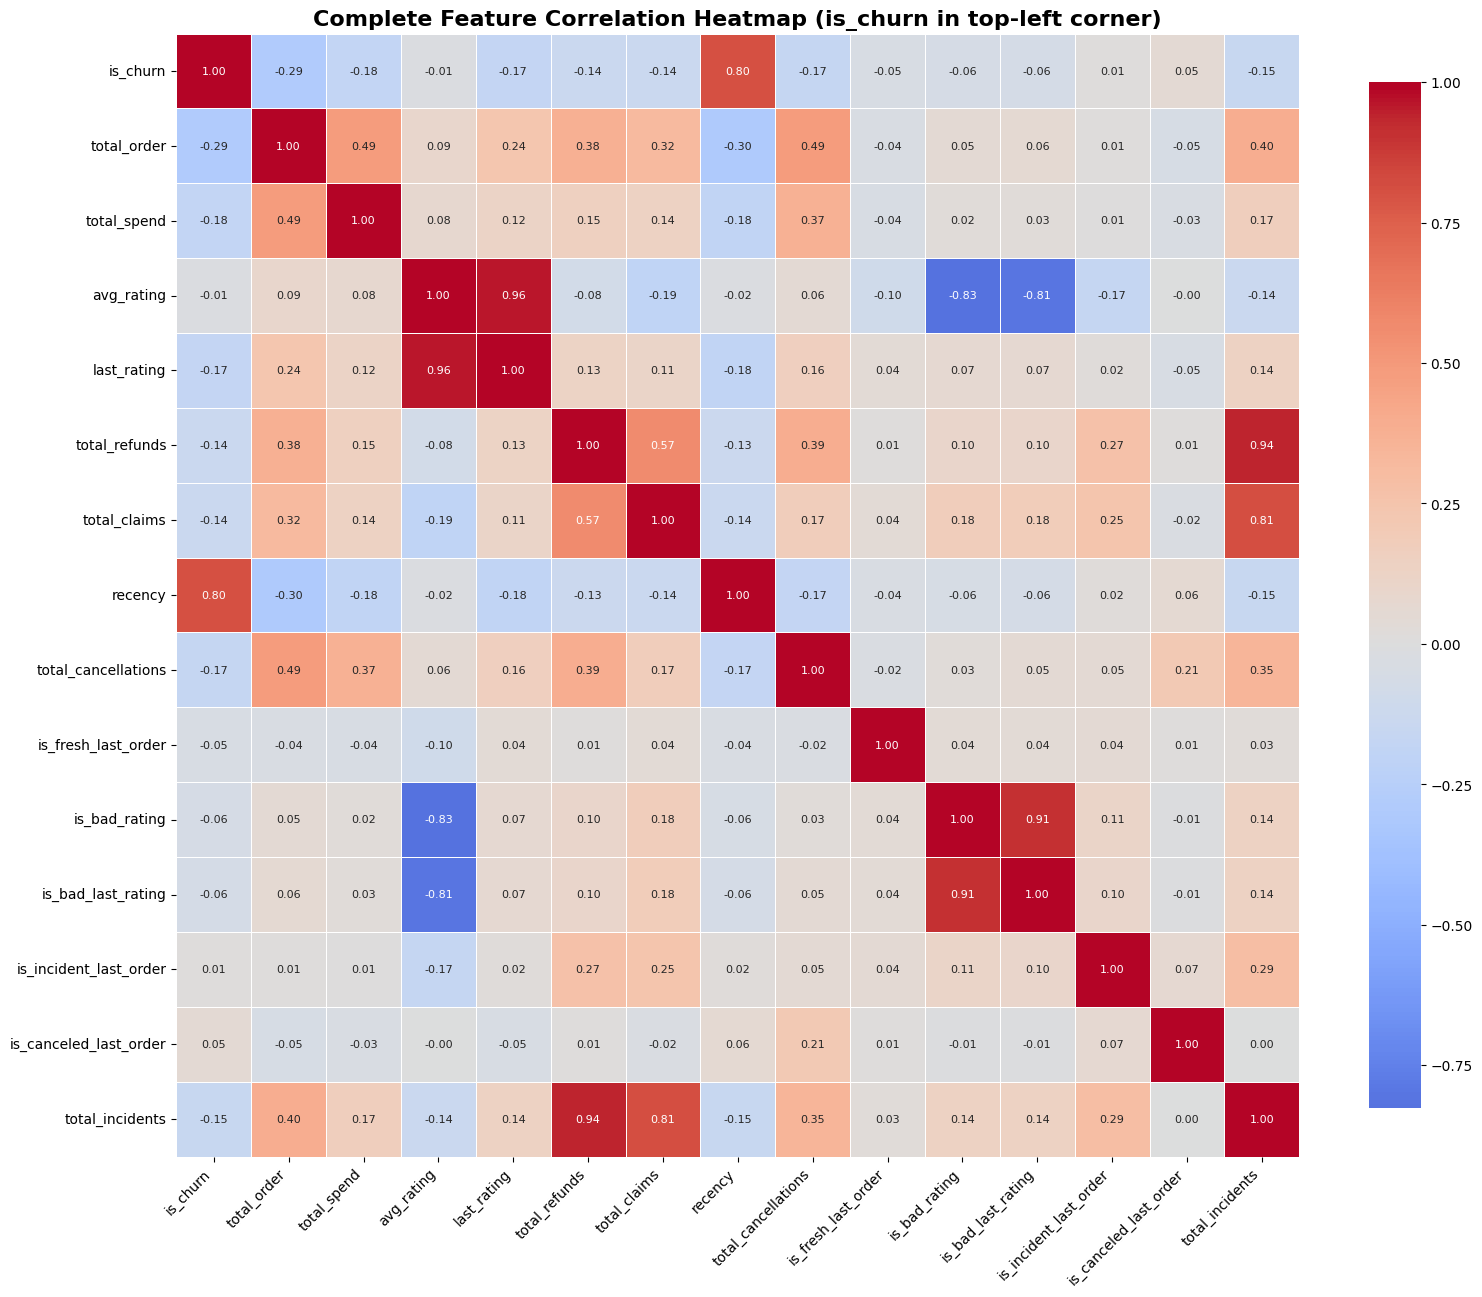

In [63]:
# 3.2 Feature Correlation Analysis

numerical_features = ['is_churn', 'total_order', 'total_spend', 'avg_rating', 'last_rating', 
                     'total_refunds', 'total_claims', 'recency', 'total_cancellations', 
                     'is_fresh_last_order',  'is_bad_rating', 'is_bad_last_rating', 
                     'is_incident_last_order', 'is_canceled_last_order', 'total_incidents']

# Create correlation matrix with ALL features
correlation_matrix = customer_features[numerical_features].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            fmt='.2f', annot_kws={'size': 8})
plt.title('Complete Feature Correlation Heatmap (is_churn in top-left corner)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [64]:
# 3.3 P-value Analysis and Feature Selection Recommendations
print("3.3 P-value Analysis and Feature Selection Recommendations")
print("=" * 60)

from scipy import stats

print("Statistical Significance Analysis:")
print("-" * 40)

# Perform t-tests for numerical features
numerical_features = ['total_order', 'total_spend', 'avg_rating', 'last_rating', 
                     'total_refunds', 'total_claims', 'total_cancellations', 
                     'is_fresh_last_order', 'recency']

t_test_results = []
for feature in numerical_features:
    churn_values = customer_features[customer_features['is_churn'] == 1][feature].dropna()
    non_churn_values = customer_features[customer_features['is_churn'] == 0][feature].dropna()
    
    if len(churn_values) > 1 and len(non_churn_values) > 1:
        t_stat, p_value = stats.ttest_ind(churn_values, non_churn_values)
        t_test_results.append({
            'Feature': feature,
            'T_Statistic': t_stat,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Effect_Size': abs(t_stat) / np.sqrt(len(churn_values) + len(non_churn_values))
        })

t_test_df = pd.DataFrame(t_test_results)
print("T-test results for numerical features:")
print(t_test_df.round(4))
print()

# Chi-square tests for categorical features
categorical_features = ['is_bad_rating', 'is_bad_last_rating', 'is_incident_last_order', 
                       'is_canceled_last_order']

chi2_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(customer_features[feature], customer_features['is_churn'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Feature': feature,
        'Chi2_Statistic': chi2,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

chi2_df = pd.DataFrame(chi2_results)
print("Chi-square test results for categorical features:")
print(chi2_df.round(4))
print()

# Feature Selection Recommendations
print("FEATURE SELECTION RECOMMENDATIONS:")
print("=" * 50)

# Categorize features by significance and effect size
high_impact_features = []
medium_impact_features = []
low_impact_features = []
exclude_features = []

# Analyze numerical features
for _, row in t_test_df.iterrows():
    if row['P_Value'] < 0.001 and row['Effect_Size'] > 0.3:
        high_impact_features.append((row['Feature'], 'High Impact'))
    elif row['P_Value'] < 0.05 and row['Effect_Size'] > 0.1:
        medium_impact_features.append((row['Feature'], 'Medium Impact'))
    elif row['P_Value'] < 0.05:
        low_impact_features.append((row['Feature'], 'Low Impact'))
    else:
        exclude_features.append((row['Feature'], 'Not Significant'))

# Analyze categorical features
for _, row in chi2_df.iterrows():
    if row['P_Value'] < 0.001:
        high_impact_features.append((row['Feature'], 'High Impact'))
    elif row['P_Value'] < 0.05:
        medium_impact_features.append((row['Feature'], 'Medium Impact'))
    else:
        exclude_features.append((row['Feature'], 'Not Significant'))

print("1. HIGH IMPACT FEATURES (KEEP - p < 0.001, strong effect):")
print("-" * 60)
for feature, impact in high_impact_features:
    print(f"   ✓ {feature}: {impact}")
print()

print("2. MEDIUM IMPACT FEATURES (KEEP - p < 0.05, moderate effect):")
print("-" * 60)
for feature, impact in medium_impact_features:
    print(f"   ✓ {feature}: {impact}")
print()

print("3. LOW IMPACT FEATURES (CONSIDER REMOVING - p < 0.05, weak effect):")
print("-" * 60)
for feature, impact in low_impact_features:
    print(f"   ⚠ {feature}: {impact}")
print()

print("4. EXCLUDE FEATURES (REMOVE - p >= 0.05, no significant difference):")
print("-" * 60)
for feature, impact in exclude_features:
    print(f"   ✗ {feature}: {impact}")
print()

# Special considerations
print("SPECIAL CONSIDERATIONS:")
print("-" * 30)
print("   • recency: EXCLUDE - Data leakage (used to create churn label)")
print("   • avg_rating: KEEP - Important for customer satisfaction")
print("   • total_incidents: KEEP - Derived feature, good predictor")
print("   • is_fresh_last_order: KEEP - Business relevant feature")
print()

# Final recommendations
print("FINAL FEATURE SELECTION RECOMMENDATIONS:")
print("=" * 50)
print("KEEP these features for modeling:")
keep_features = [f[0] for f in high_impact_features + medium_impact_features]
keep_features.extend(['avg_rating', 'total_incidents', 'is_fresh_last_order'])
keep_features = list(set(keep_features))  # Remove duplicates

for i, feature in enumerate(sorted(keep_features), 1):
    print(f"   {i:2d}. {feature}")

print(f"\nREMOVE these features:")
remove_features = [f[0] for f in exclude_features + low_impact_features]
remove_features.extend(['recency'])  # Add recency due to data leakage
remove_features = list(set(remove_features))

for i, feature in enumerate(sorted(remove_features), 1):
    print(f"   {i:2d}. {feature}")

print(f"\nTotal features to keep: {len(keep_features)}")
print(f"Total features to remove: {len(remove_features)}")
print()

# Feature importance ranking
print("FEATURE IMPORTANCE RANKING (by correlation with churn):")
print("-" * 60)
correlation_with_churn = customer_features[keep_features + ['is_churn']].corr()['is_churn'].drop('is_churn')
correlation_with_churn = correlation_with_churn.sort_values(key=abs, ascending=False)

for i, (feature, corr) in enumerate(correlation_with_churn.items(), 1):
    print(f"   {i:2d}. {feature:25s}: {corr:6.3f}")

print("\nP-value analysis and feature recommendations completed!")

3.3 P-value Analysis and Feature Selection Recommendations
Statistical Significance Analysis:
----------------------------------------
T-test results for numerical features:
               Feature  T_Statistic  P_Value Significant  Effect_Size
0          total_order     -30.8300   0.0000         Yes       0.3083
1          total_spend     -18.7334   0.0000         Yes       0.1873
2           avg_rating      -0.5482   0.5836          No       0.0142
3          last_rating     -17.4481   0.0000         Yes       0.1745
4        total_refunds     -13.6947   0.0000         Yes       0.1369
5         total_claims     -13.7401   0.0000         Yes       0.1374
6  total_cancellations     -17.0133   0.0000         Yes       0.1701
7  is_fresh_last_order      -4.7352   0.0000         Yes       0.0474
8              recency     133.4657   0.0000         Yes       1.3347

Chi-square test results for categorical features:
                  Feature  Chi2_Statistic  P_Value Significant
0           

## 4. Advanced Feature Engineering

Based on the EDA findings, 

**REMOVE these features:**

1. avg_rating  (hight p-value & low correlation with is_churn)
2. is_fresh_last_order (hight p-value & low correlation with is_churn)
3. is_incident_last_order  (hight p-value & low correlation with is_churn)
4. recency (label leaking, recency is a part of is_churn fomular )
5. total_refunds (very high correlation with totat_incident)
6. total_claims (very high correlation with totat_incident)

**CREATE NEW features:**
1. frequency_cv  ( stable frequency or variation user, nomalize by log transformation )


In [69]:
# 4. Advanced Feature Engineering

# 4.1 Remove problematic features
features_to_remove = [
    'avg_rating',           # High p-value & low correlation with is_churn
    'is_fresh_last_order',  # High p-value & low correlation with is_churn
    'is_incident_last_order', # High p-value & low correlation with is_churn
    'recency',              # Label leaking - used in is_churn formula
    'total_refunds',        #Very high correlation with total_incidents
    'last_order_date',        # Label leaking 
    'total_claims'          # Very high correlation with total_incidents
]

for feature in features_to_remove:
    if feature in customer_features.columns:
        customer_features = customer_features.drop(columns=[feature])


# 4.2 Create frequency_cv feature
# Calculate monthly orders for each customer
monthly_orders = df.groupby(['customerid', df['orderdate'].dt.to_period('M')])['so.ordernumber'].count()
monthly_orders = monthly_orders.reset_index()
monthly_orders.columns = ['customerid', 'month', 'orders_count']  # Rename columns explicitly

# Pivot to get monthly orders per customer
monthly_pivot = monthly_orders.pivot(index='customerid', columns='month', values='orders_count').fillna(0)
# Calculate CV for each customer
cv_raw = monthly_pivot.std(axis=1) / (monthly_pivot.mean(axis=1) + 1)
customer_features['frequency_cv_raw'] = customer_features['customerid'].map(cv_raw).fillna(0)

# Log transformation to reduce skewness
customer_features['frequency_cv_log'] = np.log1p(customer_features['frequency_cv_raw'])

# Normalize to [0, 1] range
cv_log_min = customer_features['frequency_cv_log'].min()
cv_log_max = customer_features['frequency_cv_log'].max()
customer_features['frequency_cv'] = (customer_features['frequency_cv_log'] - cv_log_min) / (cv_log_max - cv_log_min)



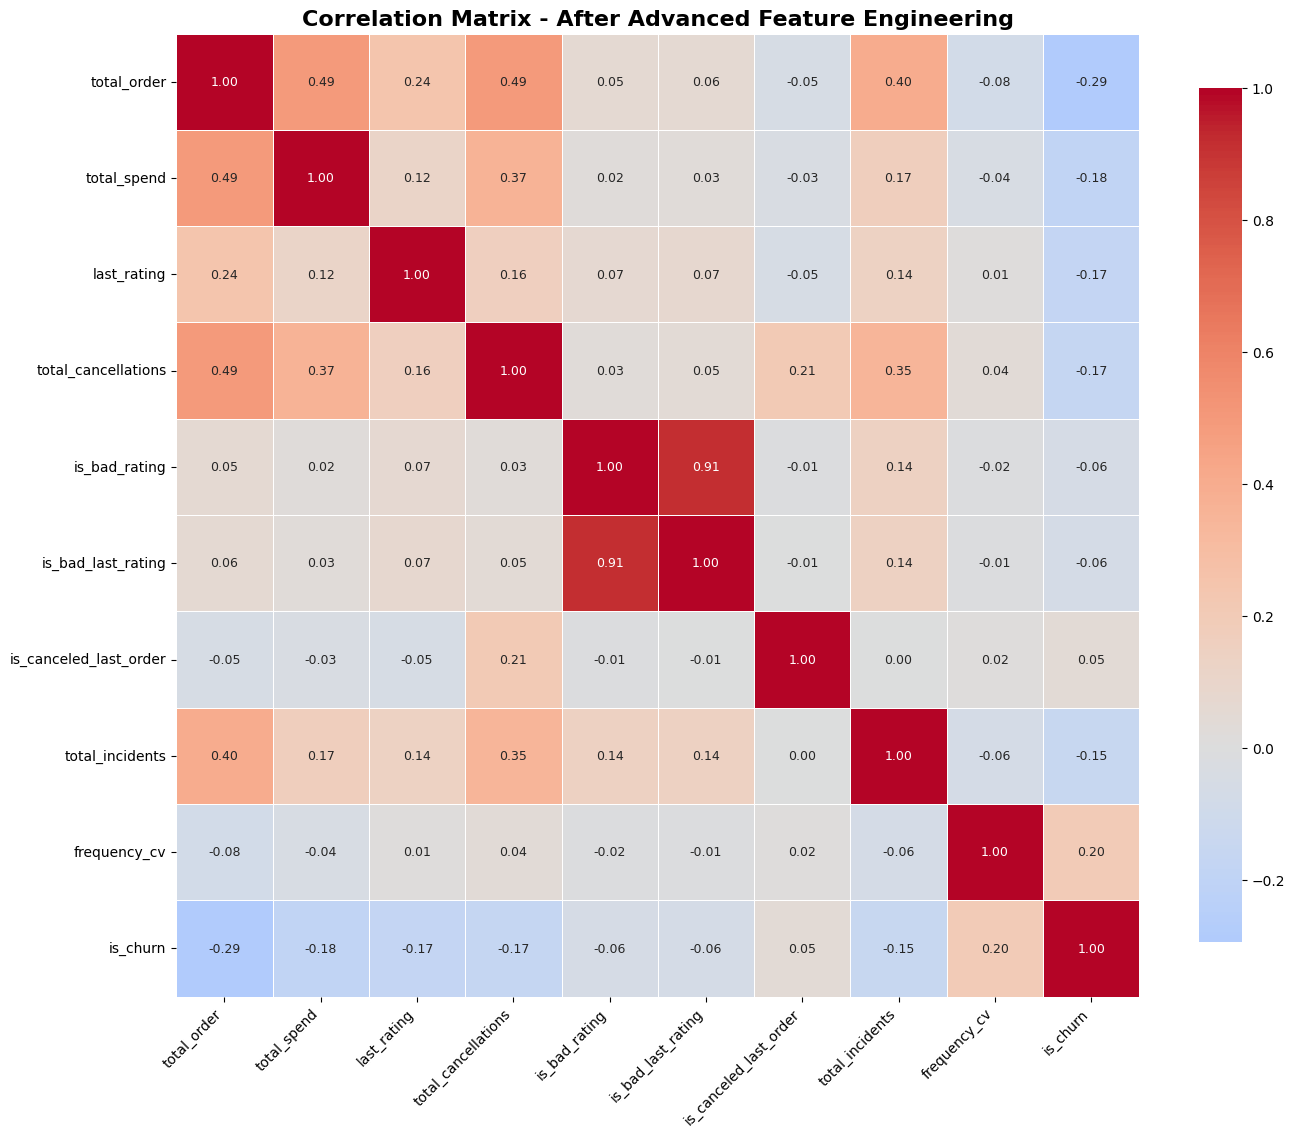

In [66]:
# Create correlation matrix with all new features and visualize again

all_features = [
    'total_order', 'total_spend', 'last_rating', 'total_cancellations',
    'is_bad_rating', 'is_bad_last_rating', 'is_canceled_last_order', 
    'total_incidents',  'frequency_cv', 'is_churn'
]
correlation_matrix_new = customer_features[all_features].corr()

# Create comprehensive correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8},
            fmt='.2f', annot_kws={'size': 9})
plt.title('Correlation Matrix - After Advanced Feature Engineering', 
          fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Model Building & Training

Now we have a rich feature set, we can train and evaluate different supervised machine learning models to predict churn.

**Model Training:**
Decision Tree: basic
Logistic Regression: Linear model
Random Forest: Ensemble, robust
XGBoost: Boosting

/var/folders/7d/9l9dg3bx74n8s13rkbh_f14m0000gn/T/ipykernel_11694/668643736.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


Training set: 8000 samples
Test set: 2000 samples
Train churn rate: 59.42%
Test churn rate: 59.45%

5.3 Model Training and Evaluation...
--------------------------------------------------
Training Decision Tree...
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
   ✓ Decision Tree trained successfully
   Accuracy: 0.698
   Precision: 0.745
   Recall: 0.748
   F1-Score: 0.746
   AUC: 0.678

Training Logistic Regression...
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
   ✓ Logistic Regression trained successfu

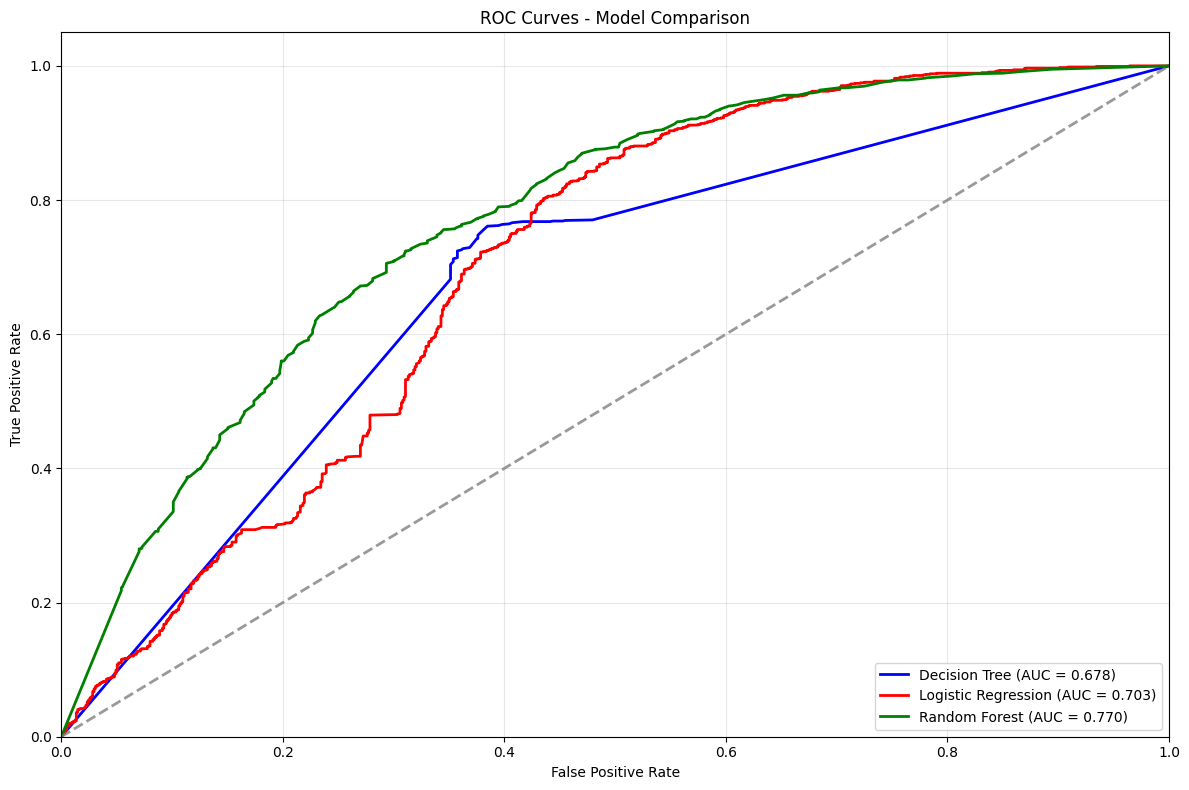

5.7 Confusion Matrices...
----------------------------------------


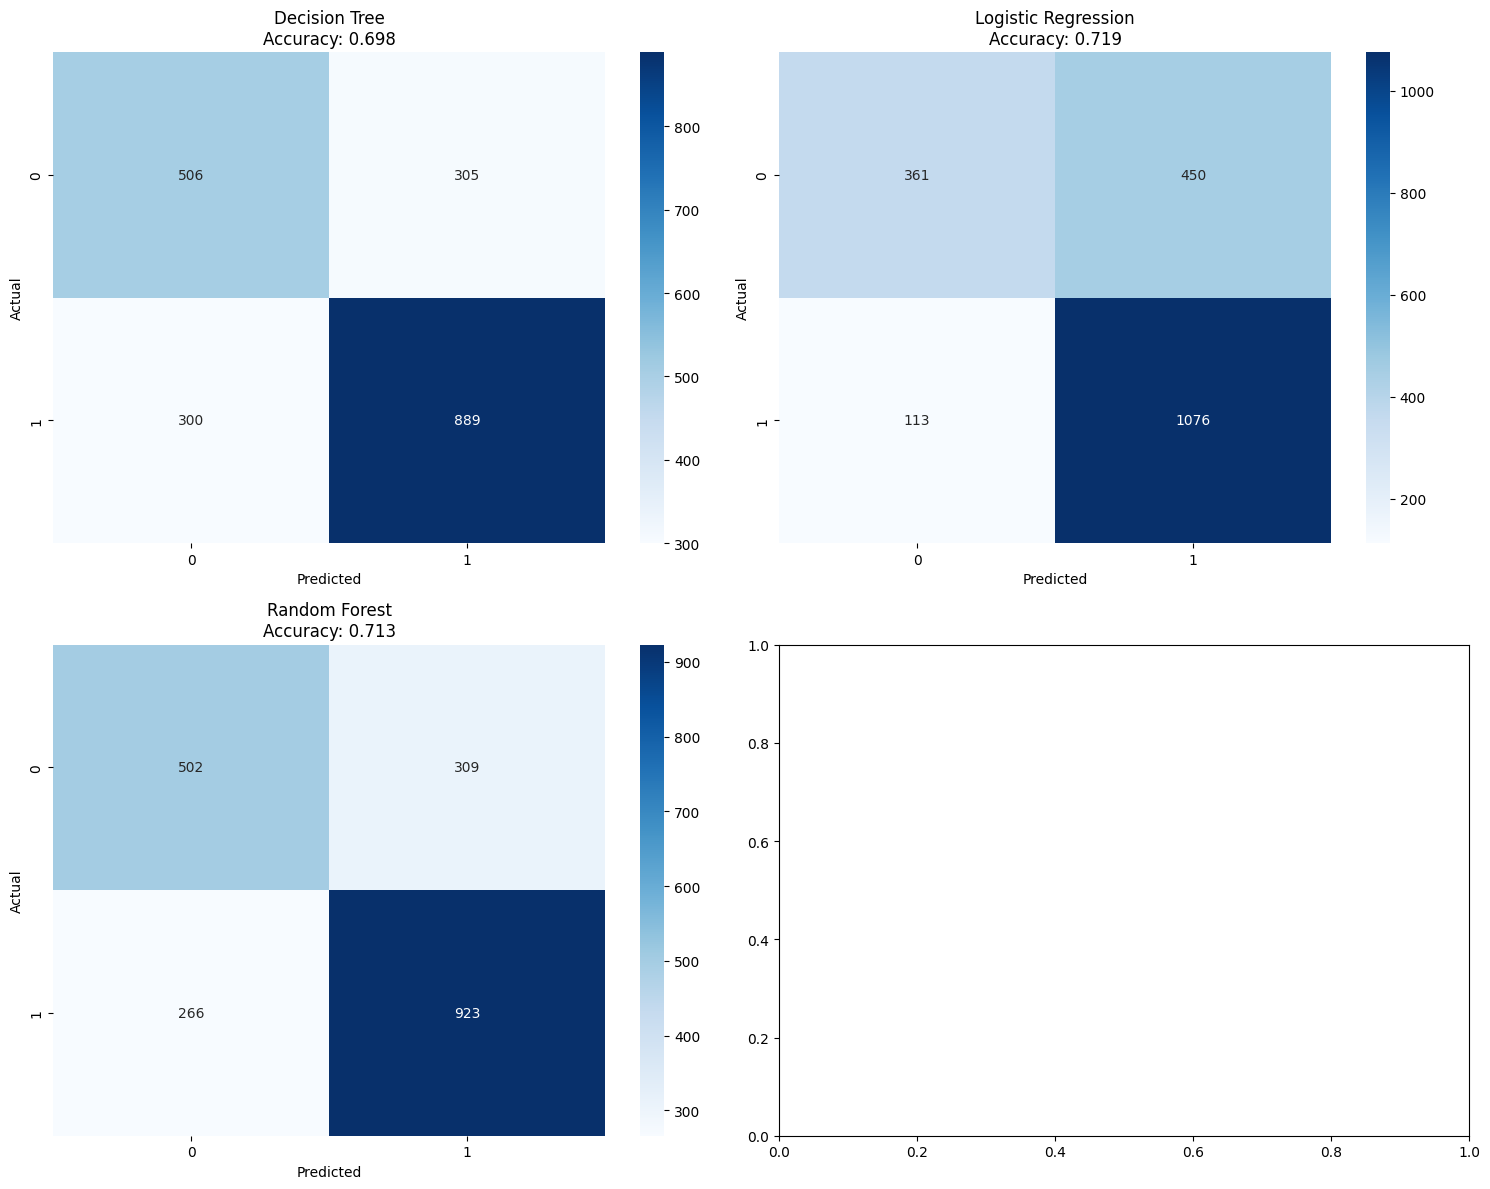

5.8 Best Model Selection...
----------------------------------------
Best performing model: Random Forest
Best AUC Score: 0.770
Best F1-Score: 0.762

5.9 Model Training Summary...
----------------------------------------
✓ Trained 3 different models
✓ Used 11 features
✓ Best model: Random Forest
✓ Test set size: 2000 samples
✓ Training completed successfully!

Model training and evaluation completed!


In [ ]:
# 5. Model Training and Evaluation
# 5.1 Data Preparation
# Select features for modeling (exclude customerid and is_churn)
feature_columns = [col for col in customer_features.columns if col not in ['customerid', 'is_churn']]
X = customer_features[feature_columns]
y = customer_features['is_churn']


# Fix missing data Convert all features to numeric, coercing errors to NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")
print()

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 5.3 Model Training and Evaluation
print("5.3 Model Training and Evaluation...")
print("-" * 50)

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Train model
    model.fit(X_train_model, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"   ✓ {name} trained successfully")
    print(f"   Accuracy: {accuracy:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    print(f"   AUC: {auc:.3f}")
    print()

# 5.4 Results Comparison
print("5.4 Results Comparison...")
print("-" * 40)

# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AUC', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.round(3).to_string(index=False))
print()

# 5.5 Feature Importance Analysis
print("5.5 Feature Importance Analysis...")
print("-" * 40)

# Get feature importance for tree-based models
importance_data = []
for name, metrics in results.items():
    if hasattr(metrics['model'], 'feature_importances_'):
        importances = metrics['model'].feature_importances_
        for i, importance in enumerate(importances):
            importance_data.append({
                'Model': name,
                'Feature': feature_columns[i],
                'Importance': importance
            })

if importance_data:
    importance_df = pd.DataFrame(importance_data)
    
    print("Top 10 Most Important Features (Random Forest):")
    print("-" * 50)
    rf_importance = importance_df[importance_df['Model'] == 'Random Forest'].sort_values('Importance', ascending=False)
    for i, row in rf_importance.head(10).iterrows():
        print(f"{row['Feature']:<25s}: {row['Importance']:.3f}")
    print()
    
    print("Top 10 Most Important Features (XGBoost):")
    print("-" * 50)
    xgb_importance = importance_df[importance_df['Model'] == 'XGBoost'].sort_values('Importance', ascending=False)
    for i, row in xgb_importance.head(10).iterrows():
        print(f"{row['Feature']:<25s}: {row['Importance']:.3f}")
    print()

# 5.6 ROC Curves Visualization
print("5.6 ROC Curves Visualization...")
print("-" * 40)

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, (name, metrics) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['probabilities'])
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{name} (AUC = {metrics["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.7 Confusion Matrices
print("5.7 Confusion Matrices...")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (name, metrics) in enumerate(results.items()):
    cm = confusion_matrix(y_test, metrics['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 5.8 Best Model Selection
print("5.8 Best Model Selection...")
print("-" * 40)

best_model_name = comparison_df.iloc[0]['Model']
best_model_metrics = results[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Best AUC Score: {best_model_metrics['auc']:.3f}")
print(f"Best F1-Score: {best_model_metrics['f1']:.3f}")
print()

# 5.9 Model Summary
print("5.9 Model Training Summary...")
print("-" * 40)
print(f"✓ Trained {len(models)} different models")
print(f"✓ Used {len(feature_columns)} features")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Test set size: {len(y_test)} samples")
print(f"✓ Training completed successfully!")

print()
print("Model training and evaluation completed!")

## 6. Results & Evaluation
- Compare Accuracy, F1-score, ROC-AUC  
- Confusion matrix  
- ROC curve  

In [ ]:
# Confusion matrix for best model (e.g. XGB)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## 6. Conclusion & Future Work

Based on the evaluation metrics, we can determine the best-performing model. This project serves as a strong foundation, and future improvements could include:

- **Feature Scaling**: Apply `StandardScaler` to numerical features for models like Logistic Regression.
- **Hyperparameter Tuning**: Use `GridSearchCV` or `RandomizedSearchCV` to find optimal parameters for models like Random Forest and XGBoost.
- **Advanced Features**: Incorporate more features from the `Products` table (e.g., proportion of fresh vs. dry goods purchased).
- **Deployment**: Integrate the best model into a real-time system to identify at-risk customers dynamically.